In [147]:
import pandas as pd
import numpy as np

In [148]:
import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [149]:
df = pd.read_csv('W1data.csv')
dfTest = pd.read_csv('W1TestData.csv')
df.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Cultivar 1,Cultivar 2,Cultivar 3
0,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,1,0,0
1,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,1,0,0
2,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,1,0,0
3,1.481555,-0.517367,0.305159,-1.289707,0.860705,1.562093,1.366128,-0.176095,0.664217,0.731870,0.406051,0.336606,2.239039,1,0,0
4,1.716255,-0.418624,0.305159,-1.469878,-0.262708,0.328298,0.492677,-0.498407,0.681738,0.083015,0.274431,1.367689,1.729520,1,0,0


In [150]:
# Get labels
y = df[['Cultivar 1', 'Cultivar 2', 'Cultivar 3']].values

# Get inputs; we define our x and y here.
X = df.drop(['Cultivar 1', 'Cultivar 2', 'Cultivar 3'], axis = 1)
X.shape, y.shape # Print shapes just to check
X = X.values

In [151]:
# Now we define all our functions

def softmax(z):
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [152]:
def softmax_loss(y,y_hat):
    # Clipping value
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    return loss


In [153]:
def loss_derivative(y,y_hat):
    return (y_hat-y)

def tanh_derivative(x):
    return (1 - np.power(x, 2))


In [154]:
#Each input is multiplied by the dot product of all the random initialised 
#weights + a bias which starts at 0 but will increaseduring trianing

In [155]:
# This is the forward propagation function
def forward_prop(model,a0):
    
    #Start Forward Propagation
    
    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3']
    
    # Do the first Linear step 
    # Z1 is the input layer x times the dot product of the weights + our bias b
    z1 = a0.dot(W1) + b1
    
    # Put it through the first activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    #Third linear step
    z3 = a2.dot(W3) + b3
    
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    a3 = softmax(z3)
    
    #Store all results in these values
    cache = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2,'a3':a3,'z3':z3}
    return cache

In [156]:
# This is the BACKWARD PROPAGATION function
def backward_prop(model,cache,y):

    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'],model['b3']
    
    # Load forward propagation results
    a0,a1, a2,a3 = cache['a0'],cache['a1'],cache['a2'],cache['a3']
    
    # Get number of samples
    m = y.shape[0]
    
    # Calculate loss derivative with respect to output
    dz3 = loss_derivative(y=y,y_hat=a3)

    # Calculate loss derivative with respect to second layer weights
    dW3 = 1/m*(a2.T).dot(dz3) #dW2 = 1/m*(a1.T).dot(dz2) 
    
    # Calculate loss derivative with respect to second layer bias
    db3 = 1/m*np.sum(dz3, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz2 = np.multiply(dz3.dot(W3.T) ,tanh_derivative(a2))
    
    # Calculate loss derivative with respect to first layer weights
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    # Calculate loss derivative with respect to first layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    dz1 = np.multiply(dz2.dot(W2.T),tanh_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    db1 = 1/m*np.sum(dz1,axis=0)
    
    # Store gradients
    grads = {'dW3':dW3, 'db3':db3, 'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

In [157]:
#TRAINING PHASE
def initialise_parameters(nn_input_dim,nn_hdim,nn_output_dim):
    # First layer weights
    W1 = 2 *np.random.randn(nn_input_dim, nn_hdim) - 1
    
    # First layer bias
    b1 = np.zeros((1, nn_hdim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(nn_hdim, nn_hdim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, nn_hdim))
    W3 = 2 * np.random.rand(nn_hdim, nn_output_dim) - 1
    b3 = np.zeros((1,nn_output_dim))
    
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3}
    return model

In [158]:
def update_parameters(model,grads,learning_rate):
    # Load parameters
    W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    W3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']
    
    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3':W3,'b3':b3}
    return model

In [159]:
def predict(model, x):
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = np.argmax(c['a3'], axis=1)
    return y_hat

In [160]:
def calc_accuracy(model,x,y):
    # Get total number of examples
    m = y.shape[0]
    # Do a prediction with the model
    pred = predict(model,x)
    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)
    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred-y))
    # Calculate accuracy
    return (m - error)/m * 100
losses = []

In [212]:
def train(model,X_,y_,learning_rate, epochs=20000, print_loss=False):
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
    
        # Pring loss & accuracy every 100 iterations
        if print_loss and i % 100 == 0:
            a3 = cache['a3']
            print('Loss after iteration',i,':',softmax_loss(y_,a3))
            y_hat = predict(model,X_)
            y_true = y_.argmax(axis=1)
            print('Accuracy after iteration',i,':',accuracy_score(y_pred=y_hat,y_true=y_true)*100,'%')
            losses.append(accuracy_score(y_pred=y_hat,y_true=y_true)*100)
    return model

Loss after iteration 0 : 1.4619703912286877
Accuracy after iteration 0 : 24.539877300613497 %
Loss after iteration 100 : 0.5410202294391878
Accuracy after iteration 100 : 79.75460122699386 %
Loss after iteration 200 : 0.4080293260109097
Accuracy after iteration 200 : 85.88957055214725 %
Loss after iteration 300 : 0.35777911648501554
Accuracy after iteration 300 : 87.73006134969326 %
Loss after iteration 400 : 0.3309813130264834
Accuracy after iteration 400 : 88.95705521472392 %
Loss after iteration 500 : 0.31100773668997195
Accuracy after iteration 500 : 88.95705521472392 %
Loss after iteration 600 : 0.29279721209183823
Accuracy after iteration 600 : 88.95705521472392 %
Loss after iteration 700 : 0.27377332699561086
Accuracy after iteration 700 : 88.95705521472392 %
Loss after iteration 800 : 0.26020299559480736
Accuracy after iteration 800 : 88.95705521472392 %
Loss after iteration 900 : 0.2451752446736815
Accuracy after iteration 900 : 88.95705521472392 %
Loss after iteration 1000 : 

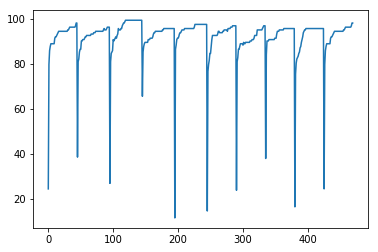

In [214]:
#need to make random start from a base of 0
np.random.seed(0)
#epochs is one full training forward and back propagation
#LEarning rate is hoow rapidly the parameters change
# This is what we return at the end
model = initialise_parameters(nn_input_dim=13, nn_hdim= 5, nn_output_dim= 3)
model = train(model,X,y,learning_rate=0.07,epochs=4500,print_loss=True)
plt.plot(losses)

In [215]:
# Get labels
yTest = dfTest[['Cultivar 1', 'Cultivar 2', 'Cultivar 3']].values

# Get inputs; we define our x and y here.
XTest = dfTest.drop(['Cultivar 1', 'Cultivar 2', 'Cultivar 3'], axis = 1)
XTest.shape, yTest.shape # Print shapes just to check
XTest = XTest.values

In [216]:
#now test on our test file

In [217]:
yTest = predict(model,XTest)

In [218]:
#change the test answers data array into a 1d array that can be compared for measuring the accuracy
answersArray = []
for index, row in dfTest[['Cultivar 1', 'Cultivar 2', 'Cultivar 3']].iterrows():
    #print(str(index) +" : "+str((row.values)))
    finalValue = 0;
    for idx, num in enumerate(row.values):
        correctedNum = idx*num
        finalValue += correctedNum
    answersArray.append(finalValue)
    #print(str(index) +":" +str(finalValue))

In [219]:
#The predicted answers
yTest

array([2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2], dtype=int64)

In [220]:
#the real answers
np.array(answersArray)

array([2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2], dtype=int64)

In [221]:
#runn an accuracy score between the predicted numbers and real answers.
accuracy_score(answersArray, yTest)

1.0